# Imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import linecache
import pandas as pd
from sklearn import preprocessing
from tqdm import trange
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.cuda.set_device(2)
import time
import math

# Help functions

In [11]:
def line_show(line_batch, text=None):
    batch = line_batch["line"][0].shape[0]
    line1 = line_batch["line"][0].numpy().reshape(batch,-1)
    line2 = line_batch["line"][1].numpy().reshape(batch,-1)
    label = line_batch["label"].numpy()
    for i in range(batch):
        ax = plt.subplot(batch/2, 2, i+1)
        plt.subplots_adjust(wspace=0.2, hspace=1.5)
        plt.plot(line1[i])
        plt.plot(line2[i])
        plt.axis
        if text:
            ax.set_title(text+str(label[i]),fontsize=12,color='r')
    
def line_show_test(line_batch, text=None):
    line1 = line_batch[0].numpy().reshape(1,-1)
    line2 = line_batch[1].numpy().reshape(1,-1)
    plt.figure()
    plt.plot(line1[0])
    plt.plot(line2[0])
    if text:
        plt.title(text,fontsize='large',fontweight='bold') 
        
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
    
def read_data_row(path, num):       
    return linecache.getline(path,num)

def normalization(l1, l2):
    pass

# Configuration Class

In [3]:
class Config():
    training_dir = "./data/train/"
    testing_dir = "./data/test/"
    train_batch_size = 16
    train_number_epochs = 30
    train_lr = 0.001
    train_m = 10.0

# Custom Dataset Class

In [4]:
class SkylineDataset(Dataset):
    
    def __init__(self,root,transform=None):
        self.root_path = root
        self.transform = transform
        self.filenames = os.listdir(self.root_path)
    def __getitem__(self,idx):
        filename = self.filenames[idx]
        file = read_data_row(os.path.join(self.root_path, filename), 1).strip().split(" ")
        line1 = np.array(list(map(int, file[0].split(',')))) # C*H*W = (1, 300, 1)
        if self.transform:
            line1 = Move()(line1)
            line1 = Rotate()(line1)
        line2 = np.array(list(map(int, file[1].split(','))))
        line = np.hstack((line1, line2))
        
        line_min, line_max = line.min(), line.max()
        line = (line-line_min)/(line_max-line_min)
        
        line1 = line[:300].reshape(1, 300, 1)
        line2 = line[300:].reshape(1, 300, 1)
        label = np.array(list(map(int, file[2])))
        sample = {"line":[line1, line2], "label":label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.filenames)
    

In [5]:
class Rotate(object):
    def __call__(self, line):
        angle = random.randint(-6,6)
        pointx = len(line)//2
        pointy = line[pointx]
        angle = float(angle) * 3.1415  / float(180)
        x = np.arange(len(line))
        y = (x-pointx) * math.sin(angle) + (line - pointy) * math.cos(angle) + pointy
        
        return y


class Move(object):
    def __call__(self, line):
        delta = random.randint(-20,20)
        return line + delta
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        line, lable = sample['line'], sample['label']
        return {'line': [torch.from_numpy(line[0]).float(), torch.from_numpy(line[1]).float()],
                'label': torch.from_numpy(lable).float()}

In [6]:
# show
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))


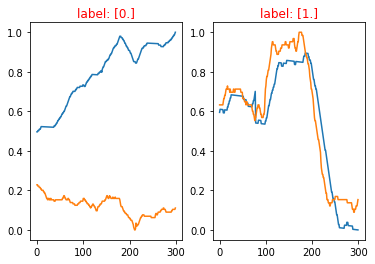

In [14]:
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = 2,
                       num_workers = 0
                       )
dataiter = iter(train_dataloader)
example_batch = next(dataiter)
line_show(example_batch, text="label: ")

# Neural Net Definition

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(2, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(4),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*4*16
        )

        self.cnn2 = nn.Sequential(
            nn.Conv1d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*8*8
        )

        self.cnn3 = nn.Sequential(
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(4),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*4*4
        )

        self.cnn4 = nn.Sequential(
            nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(2),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*2*2
        )

        self.fc1 = nn.Sequential(
            nn.Linear(300, 500),
            nn.ReLU(inplace=False),

            nn.Linear(500, 200),
            nn.ReLU(inplace=False),

            nn.Linear(200, 32),
            nn.ReLU(inplace=False))

        self.fc2 = nn.Sequential(
            nn.Linear(4, 1),
            nn.Sigmoid())

    def forward_once(self, x):

        output = self.fc1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        output = torch.cat((output1, output2), 1)

        output = self.cnn1(output)
        output = self.cnn2(output)
        output = self.cnn3(output)
        output = self.cnn4(output)

        output = output.view(-1, 1, 4).contiguous()

        output = self.fc2(output)
        return output


In [16]:
from tensorboardX import SummaryWriter
dummy_input0 = torch.rand(32,1, 300) 
dummy_input1 = torch.rand(32,1, 300) 
model = SiameseNetwork()
with SummaryWriter(comment='SiameseNetwork') as w:
    w.add_graph(model, (dummy_input0, dummy_input1))

# Loss

In [17]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        euclidean_distance = F.threshold(euclidean_distance, 0.1, 0.0, inplace=False)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 所有batch的loss

        return loss_contrastive

# Train

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = Config.train_batch_size,
                       num_workers = 0
                       )

In [20]:
net = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(),lr = Config.train_lr)

In [21]:
counter = []
loss_history = [] 
iteration_number= 0
best_acc = 0

In [22]:
def train(echoh):
    net.train()
    for i, data in enumerate(train_dataloader,0):
        line1 = data["line"][0].view(Config.train_batch_size, 1, -1)
        line2 = data["line"][1].view(Config.train_batch_size, 1, -1)
        label = data["label"]
        line1, line2 , label = line1.to(device), line2.to(device) , label.to(device)
        optimizer.zero_grad()
        output = net(line1,line2)
        loss_contrastive = criterion(output,label)
        loss_contrastive.backward()
        optimizer.step()
        
        if i %100 == 0 :
            print("Epoch {} | {} | Current loss {} ".format(epoch, i, loss_contrastive.item()))

In [23]:
def test(epoch):
    net.eval()
    
    with torch.no_grad():
        filenames = os.listdir(Config.testing_dir)
        acc_top20 = 0
        acc_top50 = 0
        acc_top100 = 0
        acc_top200 = 0
        
        for i in trange(100):
            index_target = random.randint(0, len(filenames)-1)
            file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
            line0 = np.array(list(map(int, file0[0].split(','))))
            dist = []
            for f in filenames:
                file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
                line1 = np.array(list(map(int, file1[1].split(','))))
                line = np.hstack((line0, line1))
                line_min, line_max = line.min(), line.max()
                line = (line-line_min)/(line_max-line_min)
                line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
                line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))
                
                output = net(Variable(line1).float().to(device), Variable(line2).float().to(device))
                dist.append(output.item())

            dist = pd.Series(np.array(dist)).sort_values(ascending=False)
            if index_target in dist[:20].index.tolist():
                acc_top20 += 1
            if index_target in dist[:50].index.tolist():
                acc_top50 += 1    
            if index_target in dist[:100].index.tolist():
                acc_top100 += 1
            if index_target in dist[:200].index.tolist():
                acc_top200 += 1
                
        acc_top20 /= 100.0
        acc_top50 /= 100.0
        acc_top100 /= 100.0
        acc_top200 /= 100.0
        acc_mean = (acc_top20+acc_top50+acc_top100+acc_top200) / 4
        print('epoch %d | acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f' % (epoch, 
                                                                                                    acc_top20, 
                                                                                                    acc_top50,
                                                                                                    acc_top100,
                                                                                                    acc_top200,
                                                                                                    acc_mean))
        
        # saving
        global best_acc
        if acc_mean > best_acc:
            print("saving...")
            if not os.path.isdir('./checkpoint'):
                os.mkdir('./checkpoint')
            time_str = time.strftime("%Y-%m-%d %X",time.localtime())
            torch.save(net.state_dict(), './checkpoint/ckpt.{}.{:.2f}.pth'.format(time_str, acc_mean))
            best_acc = acc_mean
    

In [ ]:
for epoch in range(0,30):
    train(epoch)
    test(epoch)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0 | 0 | Current loss 0.7430171370506287 
Epoch 0 | 100 | Current loss 0.600531816482544 
Epoch 0 | 200 | Current loss 0.6563242673873901 
Epoch 0 | 300 | Current loss 0.6807348728179932 
Epoch 0 | 400 | Current loss 0.6493878960609436 
Epoch 0 | 500 | Current loss 0.6102689504623413 
Epoch 0 | 600 | Current loss 0.5939167141914368 
Epoch 0 | 700 | Current loss 0.7090562582015991 
Epoch 0 | 800 | Current loss 0.7017120122909546 
Epoch 0 | 900 | Current loss 0.572485625743866 
Epoch 0 | 1000 | Current loss 0.581153392791748 
Epoch 0 | 1100 | Current loss 0.527734637260437 
Epoch 0 | 1200 | Current loss 0.5492935180664062 
Epoch 0 | 1300 | Current loss 0.5576683878898621 
Epoch 0 | 1400 | Current loss 0.5359431505203247 
Epoch 0 | 1500 | Current loss 0.4868730902671814 
Epoch 0 | 1600 | Current loss 0.4692642092704773 
Epoch 0 | 1700 | Current loss 0.6092714667320251 
Epoch 0 | 1800 | Current loss 0.5756057500839233 
Epoch 0 | 1900 | Current loss 0.4031781256198883 
Epoch 0 | 2000 |

# Test

In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("./checkpoint/ckpt.1.0.98.pth"))
model.to(device)

In [ ]:
# line probability show
folder_dataset_test = SkylineDataset(root=Config.testing_dir, 
                                transform=transforms.Compose([ToTensor()]))
test_dataloader = DataLoader(folder_dataset_test,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
example0 = next(dataiter)
line0 = example0["line"][0].view(1, 1, -1)
line1 = example0["line"][1].view(1, 1, -1)
label = example0["label"].numpy()
print(label)
for i in range(10):
    output = model(Variable(line0).to(device),Variable(line1).to(device))
    line_show_test((line0, line1, label),'probability: {:.8f}'.format(output.item()))
    
    example1 = next(dataiter)
    line1 = example1["line"][1].view(1, 1, -1)

In [ ]:
# acc inference
model.eval()

with torch.no_grad():
    filenames = os.listdir(Config.testing_dir)
    acc_top20 = 0
    acc_top50 = 0
    acc_top100 = 0
    acc_top200 = 0

    for i in trange(100):
        index_target = random.randint(0, len(filenames)-1)
        file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
        line0 = np.array(list(map(int, file0[0].split(','))))
        dist = []
        for f in filenames:
            file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
            line1 = np.array(list(map(int, file1[1].split(','))))
            line = np.hstack((line0, line1))
            line_min, line_max = line.min(), line.max()
            line = (line-line_min)/(line_max-line_min)
            line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
            line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))

            output = model(Variable(line1).float().to(device), Variable(line2).float().to(device))
            dist.append(output.item())

        dist = pd.Series(np.array(dist)).sort_values(ascending=False)
        if index_target in dist[:20].index.tolist():
            acc_top20 += 1
        if index_target in dist[:50].index.tolist():
            acc_top50 += 1    
        if index_target in dist[:100].index.tolist():
            acc_top100 += 1
        if index_target in dist[:200].index.tolist():
            acc_top200 += 1

    acc_top20 /= 100.0
    acc_top50 /= 100.0
    acc_top100 /= 100.0
    acc_top200 /= 100.0
    acc_mean = (acc_top20+acc_top50+acc_top100+acc_top200) / 4
    print('acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f' % ( 
                                                                                                acc_top20, 
                                                                                                acc_top50,
                                                                                                acc_top100,
                                                                                                acc_top200,
                                                                                                acc_mean))
